
Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5

Fold 1/5
Early stopping triggered at epoch 76. Restoring best model parameters.
Fold 1 Evaluation Metric: 1.0434

Fold 2/5
Early stopping triggered at epoch 121. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9160

Fold 2/5
Early stopping triggered at epoch 105. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9791

Fold 2/5
Early stopping triggered at epoch 104. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9587

Fold 2/5
Early stopping triggered at epoch 169. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9601

Fold 2/5
Early stopping triggered at epoch 193. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9606

Fold 2/5
Early stopping triggered at epoch 193. Restoring best model parameters.
Fold 1 Evaluation Metric: 0.9988

Fold 2/5
Early stopping triggered at epoch 193. Restoring best model parameters.
Fold 1 Evaluat

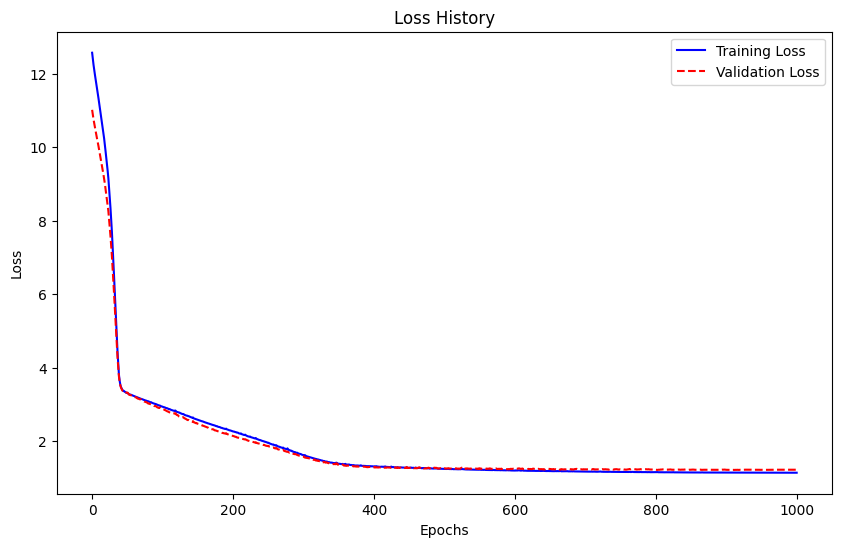

Epoch    0, Training Loss: 11.6558, Learning Rate: 0.100000
Epoch    1, Training Loss: 11.0106, Learning Rate: 0.099900
Epoch    2, Training Loss: 10.4985, Learning Rate: 0.099800
Epoch    3, Training Loss: 9.7307, Learning Rate: 0.099700
Epoch    4, Training Loss: 8.6622, Learning Rate: 0.099600
Epoch    5, Training Loss: 7.5103, Learning Rate: 0.099500
Epoch    6, Training Loss: 5.4409, Learning Rate: 0.099400
Epoch    7, Training Loss: 4.0351, Learning Rate: 0.099300
Epoch    8, Training Loss: 3.6487, Learning Rate: 0.099200
Epoch    9, Training Loss: 3.8901, Learning Rate: 0.099100
Epoch   10, Training Loss: 3.5024, Learning Rate: 0.099000
Epoch   11, Training Loss: 3.2847, Learning Rate: 0.098900
Epoch   12, Training Loss: 3.3327, Learning Rate: 0.098800
Epoch   13, Training Loss: 3.1830, Learning Rate: 0.098700
Epoch   14, Training Loss: 3.1476, Learning Rate: 0.098600
Epoch   15, Training Loss: 3.1169, Learning Rate: 0.098500
Epoch   16, Training Loss: 3.3616, Learning Rate: 0.0

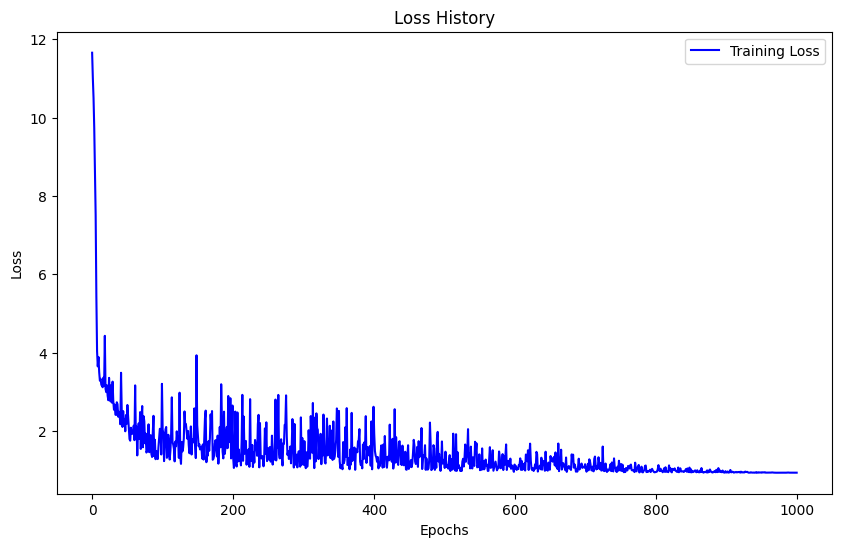

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from lib.data_loader import get_cup_dataset
from lib.neural_network import NeuralNetwork
from lib.grid_search import grid_search

X_dev, y_dev, X_test, y_test = get_cup_dataset()
input_size = X_dev.shape[1]
hidden_layers = [20, 20]
output_size = 3
layers = [input_size] + hidden_layers + [output_size]
activation_funcs = ["relu", "relu", "linear"]  # <---- l'ultimo layer è linear perché stiamo facendo una regressione

### fin qui dovrebbe essere tutto chiaro...

def build_nn_model_with_params(learning_rate=0.2, lambda_reg=0.001, reg_type="l2",
                                   lr_decay_type="linear", decay_rate=0.001, weight_init="base"):
    
    ### mi serve una funzione helper da passare alla grid search, cosìcche possa costruire un modello per ogni combinazione di parametri
        
    return NeuralNetwork(
        layers=layers,
        learning_rate=learning_rate,
        lambda_reg=lambda_reg,
        reg_type=reg_type,
        loss_function_name="mee", # <------- micheli richiede mee
        activation_function_names=activation_funcs,
        task="regression", # <--------- regression
        lr_decay_type=lr_decay_type,
        decay_rate=decay_rate,
        weight_init=weight_init
    )

param_grid = { # la griglia dei parametri da testare
        "learning_rate": [0.1, 0.2],
        "lambda_reg": [0.001, 0.01],
        "lr_decay_type": ["linear", "none"],
        "decay_rate": [0.001, 0.0],
        "weight_init": ["base", "glorot"],
}

best_params, all_results = grid_search(
        # la grid search farà la seguente cosa. 
        # per ogni combinazione di parametri:
            # 1. crea un modello con quei parametri
            # 2. fa il k-fold cross validation, quindi divide il dataset in k parti, e per ogni parte:
            #   1. addestra il modello sulle altre k-1 parti
            #   2. valuta il modello sulla parte rimanente
            #   3. calcola le performance ottenute
            # 3. calcola la media delle performance ottenute su tutte le k parti
            # 4. restituisce la media delle performance ottenute su tutte le k parti
        # dopo di che, restituisce i parametri che hanno ottenuto la migliore media delle performance
    
        model_builder=build_nn_model_with_params,
        param_grid=param_grid,
        X=X_dev,
        y=y_dev,
        k=5,
        epochs=500,       
        batch_size=32,
        early_stopping=True, # nella grid search, l'early stopping può essere indicato True anche senza un validation set, perché viene usato il k-fold cross validation. Guarda sotto, penultimo train()
        patience=10,
        min_delta=1e-4,
        n_jobs=-1, # usa tutti i core disponibili
        maximize=True, # la media va massimizzata, dato il fatto che viene usata l'accuracy [:questo è specificato nel metodo evaluate() della rete!]
        verbose=True
)

print("\nFinal Grid Search Best Result:")
print(best_params)
best_hyperparams = best_params["params"] 

# mi rebuildo la rete con i migliori params
nn_best = build_nn_model_with_params(
    learning_rate=best_hyperparams['learning_rate'],
    lr_decay_type=best_hyperparams['lr_decay_type'],
    lambda_reg=best_hyperparams['lambda_reg'],
    weight_init=best_hyperparams['weight_init']
)

# splitto il monk su dev set e test set, così da poter poi splittare il dev set in train e validation, e fare i plot sia sul train che sul validation
X_dev, y_dev, X_test, y_test = get_cup_dataset()
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=42
)

nn_best.train(
    X_train_split, y_train_split,
    epochs=1000,
    batch_size=64,
    verbose=True,
    validation_data=(X_val_split, y_val_split) # passo il validation set, così da poter fare i plot. 
                                               # Nota anche il fatto che il validation set è NECESSARIO se si intende fare early stopping (non questo caso)
)
    
nn_best.plot_loss_history() # plotto la loss sia sul train che sul validation

# OK, quindi abbiamo i nostri plot su training e validation, ora retraino sull'intero dev set, per testare sul test set

nn_best = build_nn_model_with_params(
    learning_rate=best_hyperparams['learning_rate'],
    lr_decay_type=best_hyperparams['lr_decay_type'],
    lambda_reg=best_hyperparams['lambda_reg'],
    weight_init=best_hyperparams['weight_init']
)

nn_best.train(
    X_dev, y_dev,
    epochs=1000,
    batch_size=32,
    verbose=True
)

test_mee = nn_best.evaluate(X_test, y_test)
print(f"\nBest Model Test MEE: {test_mee:.4f}")
nn_best.plot_loss_history() # questi plot non conterranno il validation set, ma solo i dati relativi al training set (che è il dev set)